In [176]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import json
import requests
print(requests.__version__)
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
%matplotlib inline

2.22.0


In [214]:
df=pd.read_csv('data/piki_dataset.csv')

In [215]:
df.head()

,timestamp,user_id,song_id,liked,personalized,spotify_popularity
0,2019-06-21 01:04:23,3720277,32192,0,1,87
1,2019-06-21 01:04:33,3720277,6801,0,1,45
2,2019-06-21 01:04:35,3720277,31643,0,1,62
3,2019-06-21 01:04:48,3720277,1864239,0,1,72
4,2019-06-21 01:05:13,3720277,38804,0,1,73


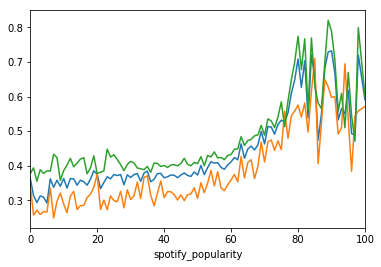

In [216]:
# all songs
df.groupby(['spotify_popularity']).mean()['liked'].plot()
df_nonpersonalized=df[df['personalized']==0]
df_nonpersonalized.groupby(['spotify_popularity']).mean()['liked'].plot()
df_personalized=df[df['personalized']==1]
df_personalized.groupby(['spotify_popularity']).mean()['liked'].plot()

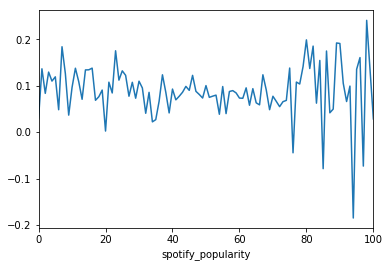

In [217]:
(df_personalized.groupby(['spotify_popularity']).mean()['liked']-df_nonpersonalized.groupby(['spotify_popularity']).mean()['liked']).plot()

In [218]:
(df_personalized.groupby(['spotify_popularity']).mean()['liked']-df_nonpersonalized.groupby(['spotify_popularity']).mean()['liked']).mean()

0.08857602811509055